# RP IM Sync

### Imports

In [1]:
# Python standard library
import os
import sys
import csv

# Scipy, etc.
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', '')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/rp/')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file

# Jupyter
from IPython.display import HTML

### Open files and preprocess data

##### Set file info

In [2]:
date = '/8-23-2017'
particle = '/293-T'
chip = '/15-30-15_4'
file_index = '3'

base_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/'+date+particle+chip

##### Open RP

In [3]:
rp_fps = 250000.


# RP data files
rp_data_file_directory = base_directory + '/rp/bts/'
rp_data_file_name = 'test_rp_'+file_index+'.bts'
rp_data_file_path = rp_data_file_directory + rp_data_file_name

rp_data = rp_file.get_data(rp_data_file_path)



# RP event files
rp_events_file_directory = base_directory + '/rp/events/'
rp_events_file_name = 'test_rp_' + file_index + '_events.json'
rp_events_file_path = rp_events_file_directory + rp_events_file_name

rp_events = rp_file.open_event_file_json(rp_events_file_path)

##### Open OI

In [4]:
oi_res_x = 512
oi_res_y = 288
oi_fps = 125000.
oi_exp = .5

# OI data files
oi_vid_file_directory = base_directory + '/oi/bin/'
oi_vid_file_name = 'test_camera_' + file_index
oi_vid_file_path = oi_vid_file_directory + oi_vid_file_name

oi_vid = oi_file.Video(oi_vid_file_path, oi_res_x, oi_res_y, oi_fps, oi_exp)


# OI event files
oi_events_file_directory = base_directory + '/oi/events/'
oi_events_file_name = 'test_camera_' + file_index + '_events.json'
oi_events_file_path = oi_events_file_directory + oi_events_file_name

oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats//pore_stats/oi/optical_imaging.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


In [5]:
print "#rp: ", len(rp_events)
print "#oi: ", len(oi_events)

#rp:  33
#oi:  1956


##### Open output file

In [6]:
output_file_directory = oi_vid_file_directory.replace('oi/bin/','')
output_file_name = oi_vid_file_name.replace('camera_','') + '_pos_amp'
output_file_path = output_file_directory + output_file_name
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/data//8-23-2017/293-T/15-30-15_4/test_3_pos_amp


##### Create stage

[-0.  1.]


/home/prestonh/Desktop/Research/pore_stats//pore_stats/oi/optical_imaging.py:441: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot([x, x + image_height/(self._norm_y[1]/self._norm_y[0])], [0, image_height], ls = '--', color = 'yellow')


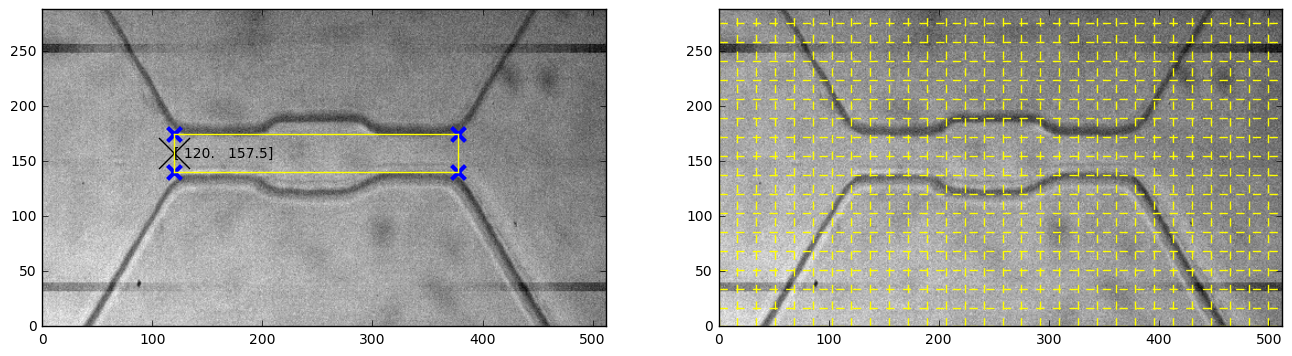

In [7]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [120, 140]
c1 = [120, 175]
c2 = [378, 175] 
c3 = [378, 140]
stage = oi.Stage(template_frame, c0, c1, c2, c3)
stage._length_microns = 150
stage.plot_stage()

##### Filter events that do not enter and exit channel

In [8]:
# Get channel enter/exit time
for event in oi_events:
    event.get_channel_enter_exit_tf(stage)

print 'length before:', len(oi_events)
oi_events = [event for event in oi_events if event._channel_enter_tf != None and event._channel_exit_tf != None]
print 'length after:', len(oi_events)

length before: 1956
length after: 1956


##### Sort events by translocation time

In [9]:
def rp_sort(event):
    return np.mean(event._data[:,0])

def oi_sort(event):
    return (event._channel_enter_tf+event._channel_exit_tf)/2.

rp_events = sorted(rp_events, key = rp_sort)
oi_events = sorted(oi_events, key = oi_sort)



### Synchronize events

In [10]:
rp_times = np.array([event._data[:,0].mean() for event in rp_events]).reshape(-1,1)

oi_times = np.array([(event._channel_enter_tf+event._channel_exit_tf)/2./oi_fps for event in oi_events]).reshape(-1,1)

### Auto-align

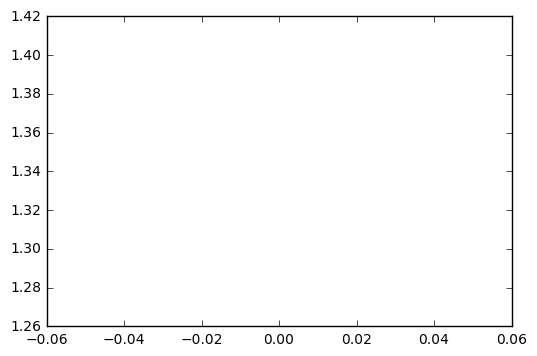

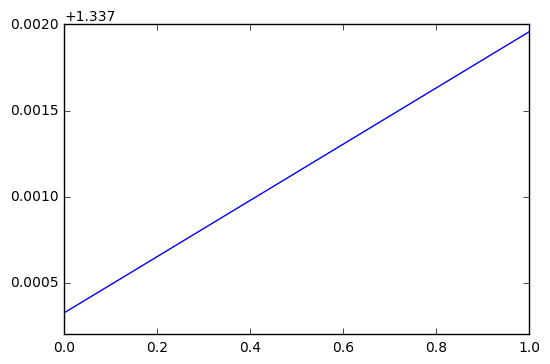

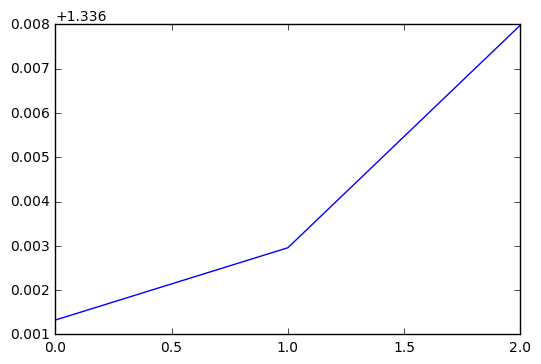

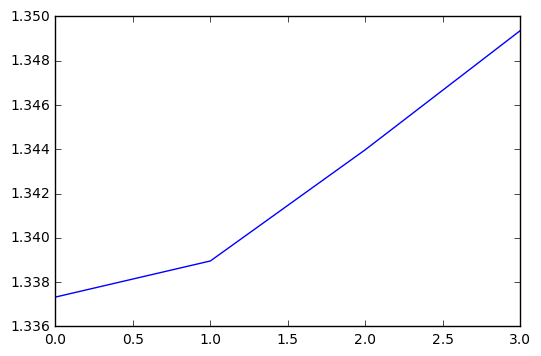

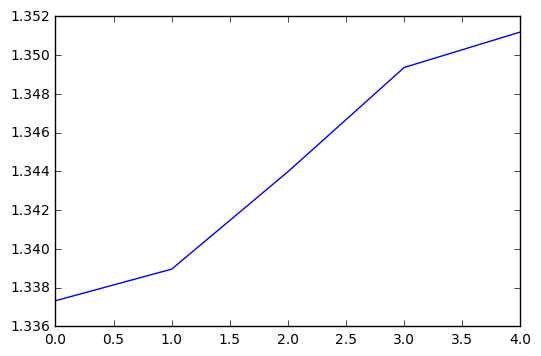

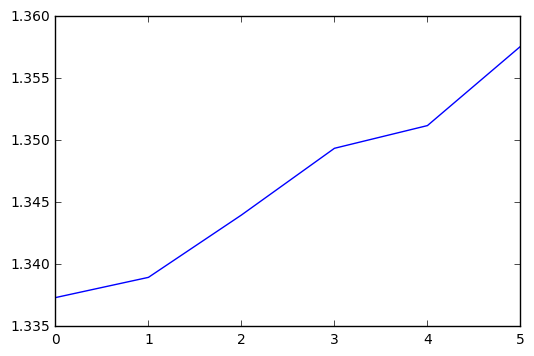

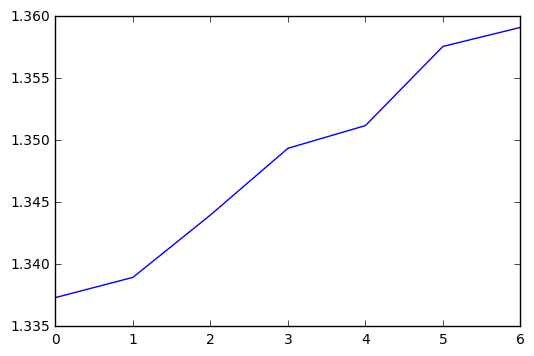

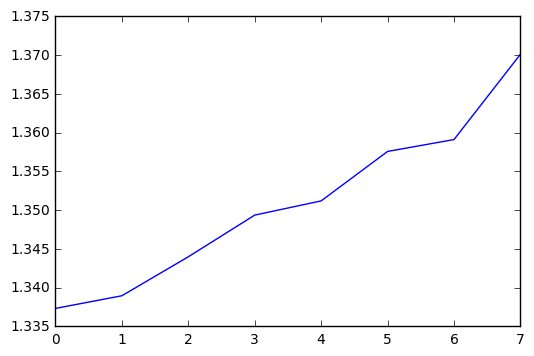

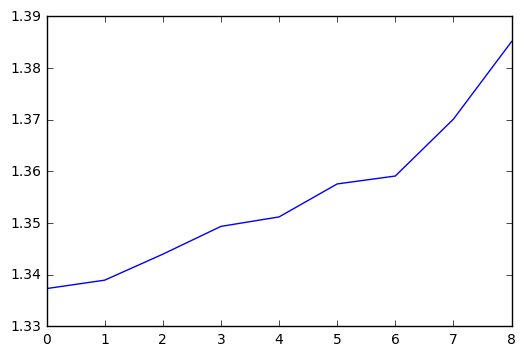

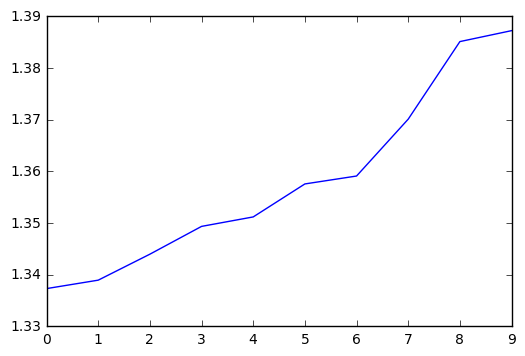

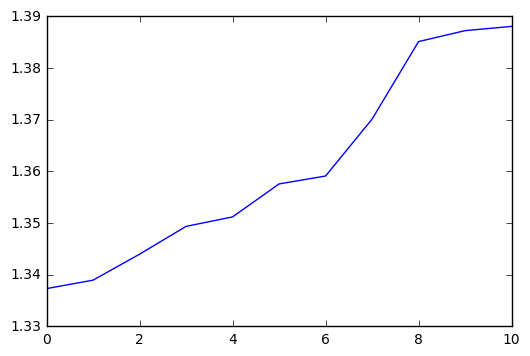

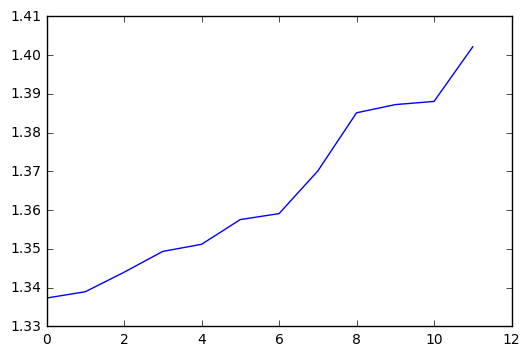

In [38]:
distances = []
for i in range(len(oi_events)):
    start_oi_event = oi_events[i]
    start_rp_event = rp_events[0]
    offset = oi_times[i] - rp_times[0]
    
    distance = 0
    for j in range(len(rp_events)):
        diffs = np.abs(oi_times - (rp_times[j] + offset)).reshape(-1)
        min_diff = np.min(diffs)
        distance += min_diff
        
    
    
    distances.append(distance)
    
    plt.plot(distances)
    plt.show()
    
    if i > 10:
        break

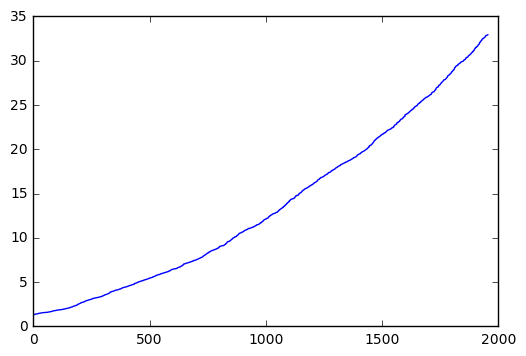

In [34]:
plt.plot(distances)
plt.show()

In [15]:
print len(oi_events)

1956
